In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2

In [2]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
src_dir = 'captcha_images' 
img_paths = [f for f in os.listdir(src_dir) if f.endswith(('.png', '.jpg'))]

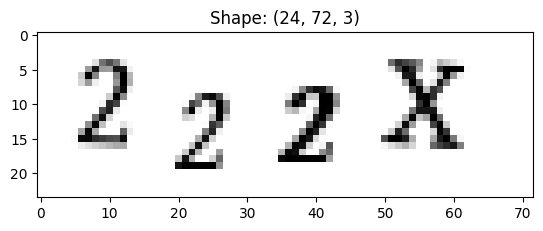

In [4]:
# View an example CAPTCHA

img = cv2.imread(os.path.join(src_dir, img_paths[0]))
plt.imshow(img)
plt.title(f'Shape: {img.shape}')
plt.show()

In [5]:
# Get list of ground-truth labels from image filenames
labels = [img_path.split('.')[0] for img_path in img_paths]

# Get count of each unique char
char_counts = {}
for label in labels:
    for char in label:
        if char not in char_counts:
            char_counts[char] = 1
        else:
            char_counts[char] += 1
            
# Sort by character
char_counts = sorted(char_counts.items())
# Convert items to two stand-alone lists
chars = [char_count[0] for char_count in char_counts]
counts = [char_count[1] for char_count in char_counts]
# Want first char on top, so reverse order
chars.reverse()
counts.reverse()

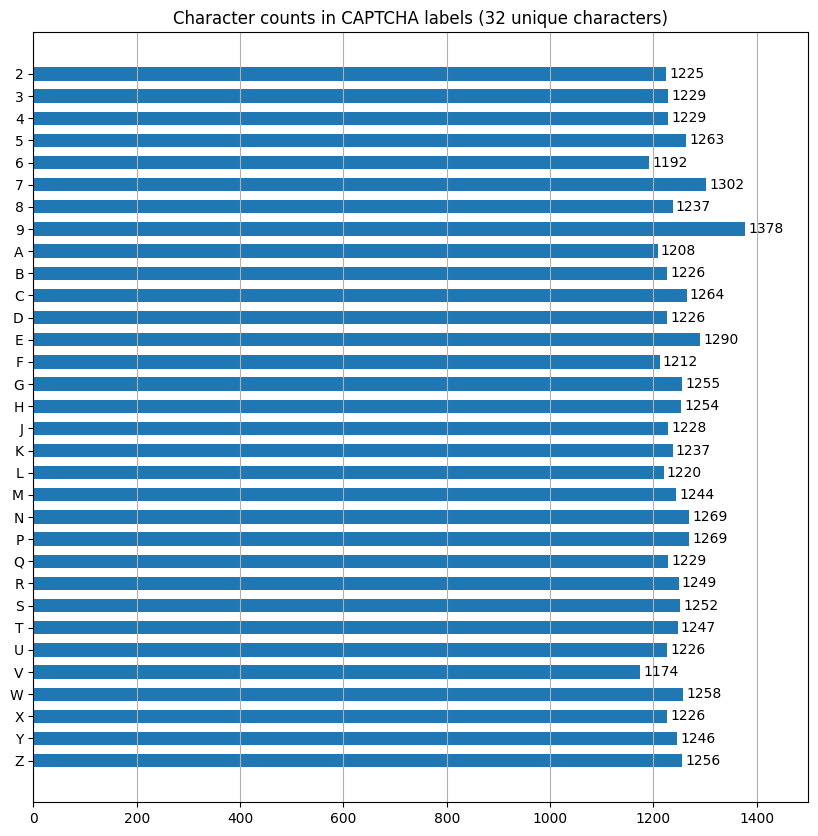

In [6]:
plt.figure(figsize=(10, 10))

bars = plt.barh(y=chars, width=counts, height=0.6)
for bar in bars:
    w = bar.get_width()
    y = bar.get_y()
    h = bar.get_height()
    plt.text(w+40, y+h/2, w, ha='center', va='center')
    
plt.xlim(0, 1500)
plt.grid(linestyle='-', axis='x')
plt.title(f'Character counts in CAPTCHA labels ({len(chars)} unique characters)')
plt.show()

# Character Segmentation

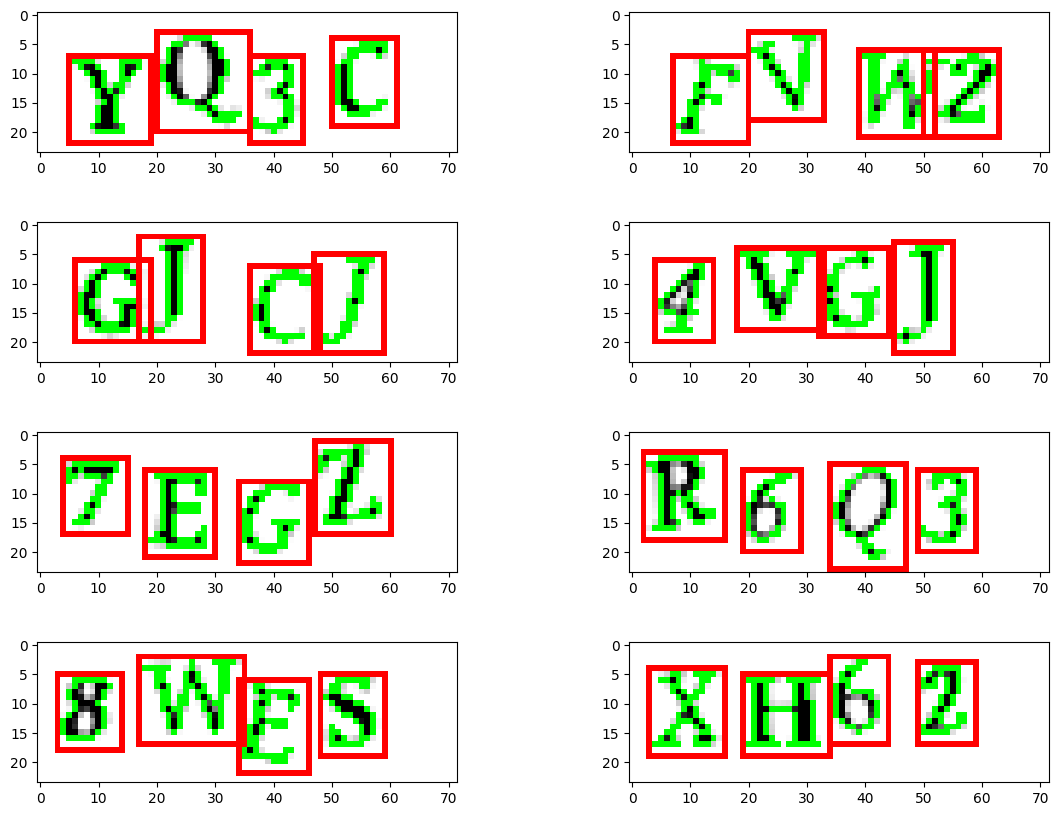

In [7]:
fig = plt.figure(figsize=(14, 10))

plt_rows = 4
plt_cols = 2
plt_iter = 1

plt.subplots_adjust(hspace=0.5)

for i in range(plt_rows*plt_cols):
    plt.subplot(plt_rows, plt_cols, plt_iter)
    
    img_index = np.random.randint(0, len(img_paths))
    # Load random image
    img = cv2.imread(os.path.join(src_dir, img_paths[img_index]))
    # Covert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take binary threshold
    ret, thresh = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY)
    # Invert image
    bit_not = cv2.bitwise_not(thresh)
    # Find contours
    contours, hierarchy = cv2.findContours(bit_not, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Draw on orignal image
    cv2.drawContours(img, contours, -1, (0, 255, 0), 1)
    # Get bounding rect of each contour
    rects = [cv2.boundingRect(c) for c in contours]
    # Sort rects by their width
    rects.sort(key=lambda x: x[2])
    
    # Deal with touching letters where one wide bounding box
    # envlopes two letters. split these in half
    while len(rects) < 4:
        # Pop widest rect
        wide_rect = rects.pop()
        x, y, w, h = wide_rect
        # Split in two
        first_half = (x, y, w//2, h)
        second_half = (x+w//2, y, w//2, h)
        rects.append(first_half)
        rects.append(second_half)
        # Re-sort rects by their width
        rects.sort(key=lambda x: x[2])
    
    for rect in rects:
        x, y, w, h = rect
        # Buffer rect by 1 pixel
        cv2.rectangle(img, (x-1, y-1), (x+w+1, y+h+1), (255, 0, 0), 1)
    
    plt.imshow(img)
    plt_iter += 1

This segementation process was written to the ```Segmenter``` class in the ```cnn_captcha_solver``` package ([see GitHub repo](https://github.com/t-ott/cnn-captcha-solver)). ***To make it easier to integrate with the Kaggle kernel, this package was split into Kaggle utility scripts and added to this notebook.***

In [8]:
from cnn_captcha_solver import segmenter

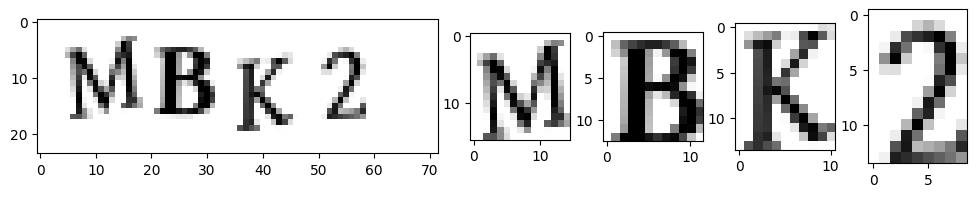

In [9]:
# Demonstrate on random image
img_index = np.random.randint(0, len(img_paths))

Segmenter = segmenter.Segmenter()
segmented_chars = Segmenter.segment_chars(os.path.join(src_dir, img_paths[img_index]), plot=True)

# Generate Training Data
Utilizing the ```DataGenerator``` class ([see on GitHub](https://github.com/t-ott/cnn-captcha-solver/blob/master/cnn_captcha_solver/data_generator.py#L9)) to extract and save individual character images to a target directory to be used as training data for the CNN model.

In [10]:
from cnn_captcha_solver import data_generator

In [11]:
DataGenerator = data_generator.DataGenerator(src_dir, train_size=0.75, random_seed=1)

In [12]:
# Extract training data from training set CAPTCHA images,
# generating ~4*len(test_set) individual character images

DataGenerator.extract_train_set('train', train_annotation_file='train_annotations.csv')

Segmenting chars from 7466 images...
Working on char 0...
Working on char 2000...
Working on char 4000...
Working on char 6000...
Working on char 8000...
Working on char 10000...
Working on char 12000...
Working on char 14000...
Working on char 16000...
Working on char 18000...
Working on char 20000...
Working on char 22000...
Working on char 24000...
Working on char 26000...
Working on char 28000...
Done! Saving filename/numeric class label key to file: train_annotations.csv


In [13]:
# Copy the test set CAPTCHA images to test folder, images
# will remain unsegmented until model testing

DataGenerator.save_test_set('test')

Copying 2489 images to test...
Copied 2489 images to test


In [14]:
# Save a label key file that shows match between CAPTCHA
# characters and their corresponding integer label, e.g.
# '2' = 0, 'G' = 14, 'Q' = 22

DataGenerator.save_label_dict('label_key.csv')

# Prepare PyTorch Dataset and Data Loaders
A custom PyTorch dataset will be defined using the ```CharsDataset``` class ([see on GitHub](https://github.com/t-ott/cnn-captcha-solver/blob/master/cnn_captcha_solver/chars_dataset.py#L8)).

In [15]:
from cnn_captcha_solver import chars_dataset
from torch.utils.data import random_split, DataLoader

In [16]:
CharsDataset = chars_dataset.CharsDataset('train_annotations.csv', 'train')

In [17]:
# What is 80% of dataset size?
round(len(CharsDataset)*0.8)

23891

In [18]:
train_set, val_set = random_split(CharsDataset, [24000, len(CharsDataset)-24000])

In [19]:
train_loader = DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=32, shuffle=True)

# Train CNN Model
Training a convolutional neural network model built with PyTorch. Architecture is defined in the ```Model``` class of the ```cnn_captcha_solver``` package ([see on GitHub](https://github.com/t-ott/cnn-captcha-solver/blob/master/cnn_captcha_solver/model.py#L3)).

In [38]:
from cnn_captcha_solver import model
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.autograd import Variable

In [39]:
Model = model.Model()

In [40]:
val_iter = iter(val_loader)

In [41]:
optimizer = Adam(Model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()
epochs = 5

In [42]:
# Training and validation of model

# Will accumulate loss for learning curve plot
train_loss_history = []
val_loss_history = []

for epoch in range(epochs):        
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)   # batch x (char image)
        b_y = Variable(y)   # batch y (target label, as int)
        output = Model(b_x)
        loss = criterion(output, b_y) 
        train_loss_history.append(loss.data)
        optimizer.zero_grad()           
        loss.backward()                 
        optimizer.step()
        
        # Evaluate on validation set every 50 batches
        if step % 50 == 0:
            val_x, val_y = next(val_iter)
            val_output = Model(val_x)
            val_loss = criterion(val_output, val_y)
            val_loss_history.append(val_loss.data)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data, '| val loss: %.4f' % val_loss.data)

Epoch:  0 | train loss: 3.5252 | val loss: 3.4310
Epoch:  0 | train loss: 2.4909 | val loss: 2.3235
Epoch:  0 | train loss: 0.8198 | val loss: 0.8848
Epoch:  0 | train loss: 0.3229 | val loss: 0.3734
Epoch:  0 | train loss: 0.6055 | val loss: 0.1848
Epoch:  0 | train loss: 0.1785 | val loss: 0.1403
Epoch:  0 | train loss: 0.0550 | val loss: 0.1072
Epoch:  0 | train loss: 0.0695 | val loss: 0.1159
Epoch:  0 | train loss: 0.0503 | val loss: 0.0898
Epoch:  0 | train loss: 0.0464 | val loss: 0.0336
Epoch:  0 | train loss: 0.3524 | val loss: 0.0500
Epoch:  0 | train loss: 0.1094 | val loss: 0.0318
Epoch:  0 | train loss: 0.0761 | val loss: 0.0430
Epoch:  0 | train loss: 0.2524 | val loss: 0.0879
Epoch:  0 | train loss: 0.0205 | val loss: 0.0197
Epoch:  1 | train loss: 0.0598 | val loss: 0.0354
Epoch:  1 | train loss: 0.0148 | val loss: 0.1061
Epoch:  1 | train loss: 0.0531 | val loss: 0.0151
Epoch:  1 | train loss: 0.0511 | val loss: 0.0229
Epoch:  1 | train loss: 0.0152 | val loss: 0.2026


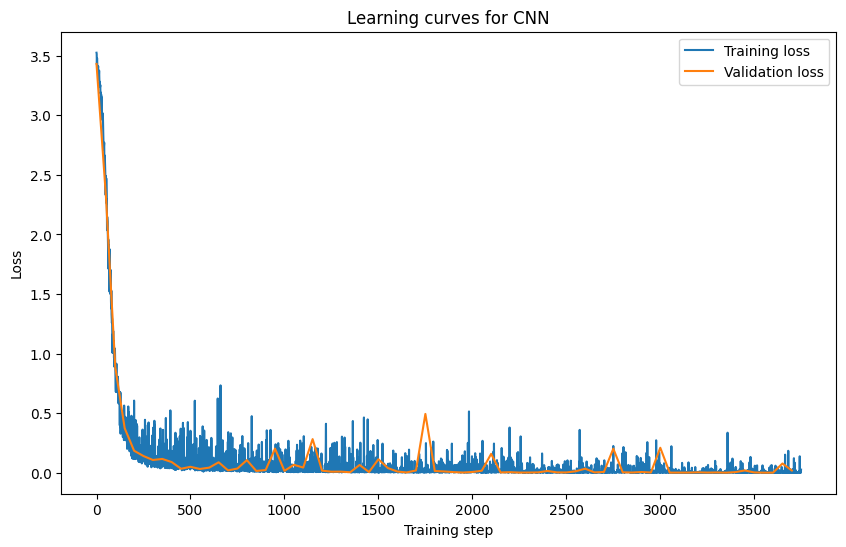

In [43]:
# Plotting learning curve

train_loss_history_x = np.arange(0, len(train_loss_history))

# Only have validation loss every 50 batches
val_loss_history_x = np.arange(0, len(val_loss_history)*50, 50)

plt.figure(figsize=(10, 6))
plt.plot(train_loss_history_x, train_loss_history, label='Training loss')
plt.plot(val_loss_history_x, val_loss_history, label='Validation loss')
plt.legend()
plt.title('Learning curves for CNN')
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.show()

In [44]:
# Save state dictionary of trained model
torch.save(Model.state_dict(), 'Model_state_dict.pt')

# Evaluate Model
Evaluate the trained model on the test set using the ```Evaluator``` class of the ```cnn_captcha_solver``` package ([see on GitHub](https://github.com/t-ott/cnn-captcha-solver/blob/master/cnn_captcha_solver/evaluator.py#L11)).

In [1]:
from cnn_captcha_solver import evaluator
from cnn_captcha_solver import model
from cnn_captcha_solver import chars_dataset

In [2]:
Model = model.Model()
CharsDataset = chars_dataset.CharsDataset('train_annotations.csv', 'train')
Evaluator = evaluator.Evaluator(Model,
                      transform=CharsDataset.transform,
                      label_key='label_key.csv',
                      model_state_dict='Model_state_dict.pt')

c:\Users\awfan\Desktop\vscode\python\GDG\captcha\cnn_captcha_solver\evaluator.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.Model.load_state_dict(torch.load(mode

In [10]:
EvaluatorResults = Evaluator.evaluate_test_set('test')

In [15]:
EvaluatorResults.captcha_accuracy

0.974286862193652

In [14]:
EvaluatorResults.char_accuracy

0.9930695058256328

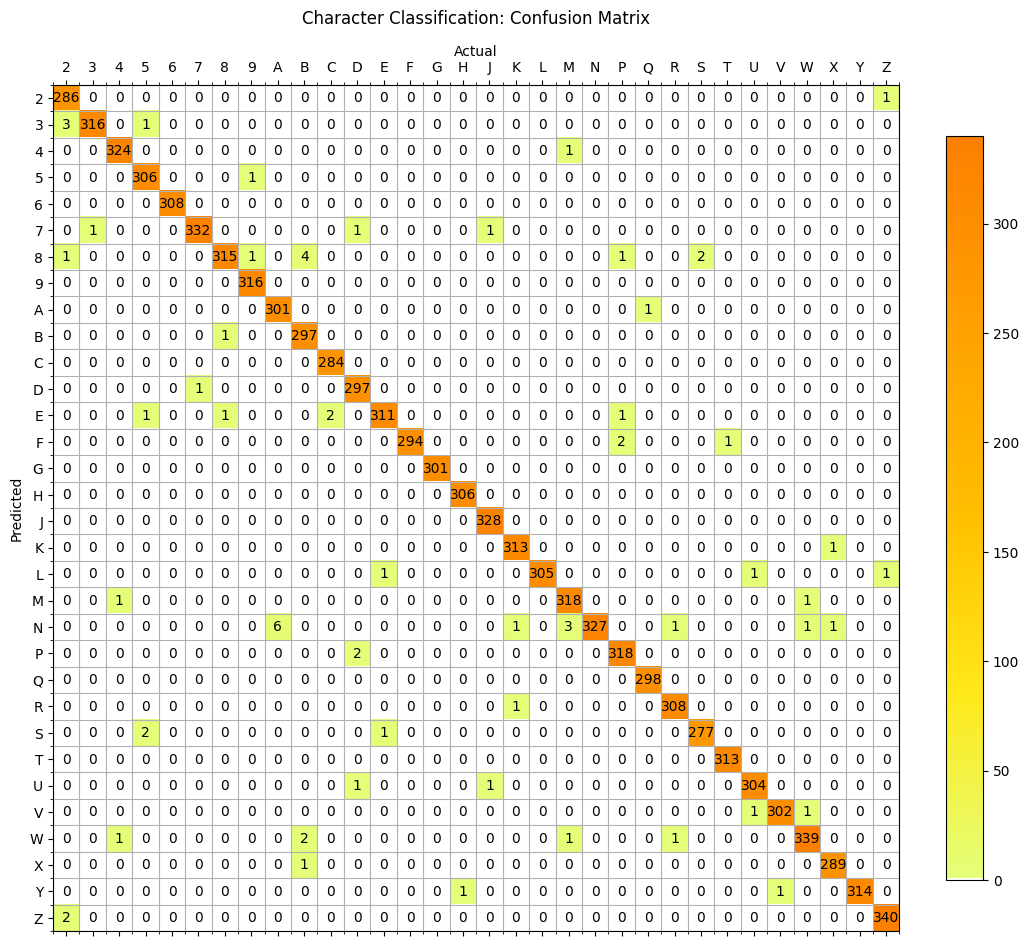

In [16]:
EvaluatorResults.plot_confusion_matrix()

# Potential Improvements

The error rate of the character classification model is quite low. In order to correctly solve a given CAPTCHA, every character needs to be correctly classified. If only one of the four characters is incorrectly classified, the CAPTCHA prediction will be incorrect. With this current approach, the only way to improve the overall accuracy of CAPTCHA predictions is to:
1) Improve the character segmentation process to provide cleaner/more reliable training data for the classification model and re-train, or
2) Improve the character classification model itself.

Further alterations to the classification model architecture may improve the classification accuracy. No systematic hyperparameter tuning has been performed on the model thus far. My gut says that character segmentation improvements would likely be more effective. Dealing with "smushed" pairs of letters is currently done by splitting the pair in half. This does not work very well with letters that have inconsisent widths. For example:

Predicted: L | Actual: L
Predicted: 4 | Actual: 4
Predicted: M | Actual: M
Predicted: U | Actual: J


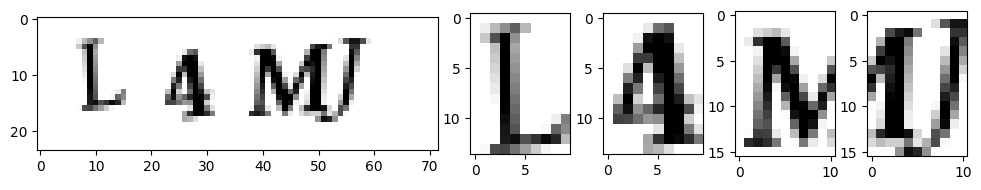

In [52]:
prediction = Evaluator.predict(os.path.join(src_dir, 'L4MJ.png'), print_results=True, plot_segmentation=True)

Another problem with this system is it only manages CAPTCHA text that is four characters in length. It could not manage variable length CAPTCHA text.

## 產生模型之後，以後開啟檔案只須執行以下程式即可測試

>下載以下圖片，並在上面寫英文或數字，數字可為1~9，英文不包含I和O ( 與數字幾乎相同，難以判別 )，總共四位數 

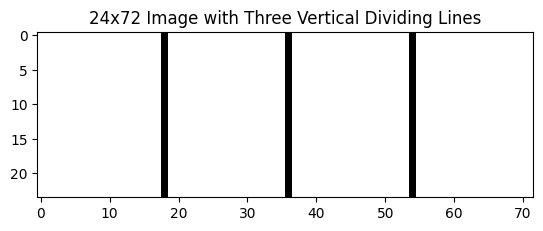

True

In [47]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Create a blank 24x72 image with white background
image = np.ones((24, 72, 3), dtype=np.uint8) * 255

# Draw three vertical lines to divide the image into three equal parts
cv2.line(image, (18, 0), (18, 24), (0, 0, 0), 1)
cv2.line(image, (36, 0), (36, 24), (0, 0, 0), 1)
cv2.line(image, (54, 0), (54, 24), (0, 0, 0), 1)

# Display the image
plt.imshow(image)
plt.title('24x72 Image with Three Vertical Dividing Lines')
plt.show()
cv2.imwrite('blank_image.png', image)

In [48]:
from cnn_captcha_solver import evaluator
from cnn_captcha_solver import model
from cnn_captcha_solver import chars_dataset

In [49]:
Model = model.Model()
CharsDataset = chars_dataset.CharsDataset('train_annotations.csv', 'train')
Evaluator = evaluator.Evaluator(Model,
                      transform=CharsDataset.transform,
                      label_key='label_key.csv',
                      model_state_dict='Model_state_dict.pt')

c:\Users\awfan\Desktop\vscode\python\GDG\captcha\cnn_captcha_solver\evaluator.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.Model.load_state_dict(torch.load(mode

>將圖片放入photo資料夾，並命名為abcd.png，如果要用自己的命名就將```own_image_path = 'photo//abcd.png' ```//後面的檔名更改成自己的名稱，英文必須參考train資料夾中的圖片，不然可能分辨不出來

>label_key.csv儲存每個字代表的編號(label)，train_annotations.csv儲存每張位於train資料夾的圖片的label，透過搜尋可以功能可以找到想要的英文字母，只須查詢該字母對應的編號

For some reason more than 4 characters were identified in the CAPTCHA! Returning the widest four...
For some reason more than 4 characters were identified in the CAPTCHA! Returning the widest four...
Predicted: J | Actual: a
Predicted: N | Actual: b
Predicted: Q | Actual: c
Predicted: R | Actual: d
Prediction: [('J', 'a'), ('N', 'b'), ('Q', 'c'), ('R', 'd')]


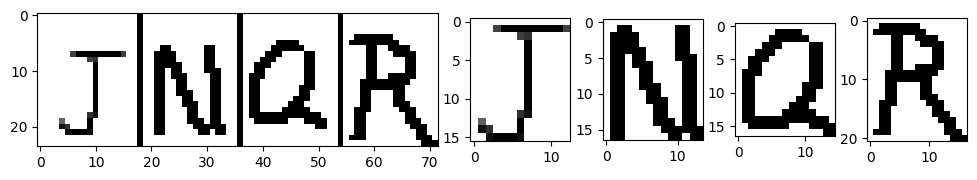

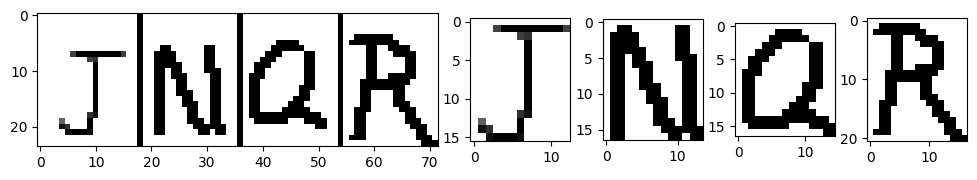

In [50]:
from cnn_captcha_solver import segmenter
own_image_path = 'photo//abcd.png'  # Path to your own image

Segmenter = segmenter.Segmenter()
segmented_chars = Segmenter.segment_chars(own_image_path, plot=True)

# 使用Evaluator進行預測
prediction = Evaluator.predict(own_image_path, print_results=True, plot_segmentation=True)

print("Prediction:", prediction)